# Consumer Behavior Analytics - Data Modelling

**Libraries and imports**

In [56]:
# Basic DS libraries
import pandas as pd
import numpy as np

# DataViz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data libraries
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats

# Models
from sklearn.linear_model import LogisticRegression

# Notebook setup
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
# Loading customers exposed
customers_exposed = pd.read_csv('../data/customers_exposed.csv', parse_dates = ['Dt_Customer'])

# Loading customers whole
customers_whole = pd.read_csv('../data/customers_whole.csv', parse_dates = ['Dt_Customer'])

In [3]:
customers_exposed.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Income_PerCap,Prop_Spending_Income_pc,Avg_Ticket,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,58138.0,0.027813,64.68,57
1,4855,1974,PhD,Together,30351.0,1,0,2013-06-06,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,1,10117.0,0.004547,7.67,40
2,5899,1950,PhD,Together,5648.0,1,1,2014-03-13,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,0,1412.0,0.034703,24.50,64
3,2114,1946,PhD,Single,82800.0,0,0,2012-11-24,23,1006,22,115,59,68,45,1,7,6,12,3,0,0,1,1,0,0,1,82800.0,0.015882,50.58,68
4,6565,1949,Master,Married,76995.0,0,1,2013-03-28,91,1012,80,498,0,16,176,2,11,4,9,5,0,0,0,1,0,0,0,25665.0,0.069433,68.54,65


## Data Preparation

In [4]:
# Transforming datetime feature to numeric feature
customers_exposed['Dt_Customer_InDays'] = customers_exposed['Dt_Customer'] - customers_exposed['Dt_Customer'].min()
customers_exposed['Dt_Customer_InDays'] = (customers_exposed['Dt_Customer_InDays'] / \
                                                       np.timedelta64(1, 'D')).astype(int) + 1

In [5]:
# Splittin data into train and test DFs
X = customers_exposed.drop(['ID', 'Response', 'Dt_Customer'], axis = 1)
y = customers_exposed['Response']

In [6]:
X = pd.get_dummies(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 7)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((485, 37), (485,), (122, 37), (122,))

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .2, random_state = 7)

In [10]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((388, 37), (388,), (97, 37), (97,))

In [301]:
# Separating numeric features in a list
numeric_features = [
#     'Year_Birth', 
    'Income', 
    'Kidhome',                
    'Teenhome', 
    'Recency', 
    'MntWines', 
    'MntFruits',
    'MntMeatProducts', 
    'MntFishProducts', 
    'MntSweetProducts',
    'MntGoldProds', 
    'NumDealsPurchases', 
    'NumWebPurchases',
    'NumCatalogPurchases', 
    'NumStorePurchases', 
    'NumWebVisitsMonth', 
    'Income_PerCap',
    'Prop_Spending_Income_pc', 
    'Avg_Ticket', 
    'Age', 
    'Dt_Customer_InDays'
]

In [302]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()
df["vif_index"] = [vif(customers_exposed[numeric_features].values, i) for i in range(customers_exposed[numeric_features].shape[1])]
df["feature"] = customers_exposed[numeric_features].columns
df

,vif_index,feature
0,51.608195,Income
1,3.584785,Kidhome
2,3.805009,Teenhome
3,3.442364,Recency
4,16.987244,MntWines
5,3.066530,MntFruits
6,8.244089,MntMeatProducts
7,3.411236,MntFishProducts
8,3.162690,MntSweetProducts
9,2.972621,MntGoldProds


In [303]:
# Listing features names if feature has outlier
to_robust_scale = []
for feature in numeric_features:
    
    Q1 = np.percentile(customers_exposed[feature].sort_values(), 25, interpolation = 'midpoint')  
    Q3 = np.percentile(customers_exposed[feature].sort_values(), 75, interpolation = 'midpoint')  

    IQR = Q3 - Q1  
    
    low_lim = Q1 - 1.5 * IQR 
    up_lim = Q3 + 1.5 * IQR 

    if (customers_exposed[feature] > up_lim).any() or (customers_exposed[feature] < low_lim).any(): 
         to_robust_scale.append(feature)

to_robust_scale

['MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds',
 'NumDealsPurchases',
 'NumWebVisitsMonth',
 'Income_PerCap',
 'Prop_Spending_Income_pc',
 'Avg_Ticket']

In [304]:
to_standardize = [feature for feature in numeric_features if feature not in to_robust_scale]
to_standardize

['Income',
 'Kidhome',
 'Teenhome',
 'Recency',
 'MntWines',
 'NumWebPurchases',
 'NumCatalogPurchases',
 'NumStorePurchases',
 'Age',
 'Dt_Customer_InDays']

In [305]:
robust_scaler = RobustScaler()
robust_scaler.fit(X_train[to_robust_scale])
X_train[to_robust_scale] = robust_scaler.transform(X_train[to_robust_scale])

In [306]:
stand_scaler = StandardScaler()

stand_scaler.fit(X_train[to_standardize])
X_train[to_standardize] = stand_scaler.transform(X_train[to_standardize])

In [307]:
X_train.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Income_PerCap,Prop_Spending_Income_pc,Avg_Ticket,Age,Dt_Customer_InDays,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
523,0.649399,0.503782,-0.643008,-0.739481,-1.456681,1.839603,1.817204,1.263609,0.097222,0.052083,-0.628821,0.0,1.905093,-0.031754,0.437187,0.75,0,0,0,0,0,0,0.279536,1.133917,0.978875,-0.649399,-1.471897,0,0,0,0,1,0,0,0,1,0
576,0.404375,0.177987,-0.643008,1.076460,0.465041,0.303350,-0.290323,-0.108869,-0.291667,-0.072917,-0.104803,3.0,1.519503,-0.031754,0.437187,0.25,0,1,1,0,0,0,0.148863,-0.073985,-0.295949,-0.404375,1.044072,0,0,1,0,0,0,0,1,0,0
385,-1.065773,-0.720858,1.418869,1.076460,-0.667402,-1.196383,-0.440860,-0.329052,-0.291667,-0.385417,-0.524017,0.0,-1.565217,-1.400704,-1.080063,0.50,1,0,0,0,1,0,-0.641028,-0.812537,-0.689866,1.065773,1.458581,0,0,0,0,1,0,0,0,1,0
133,-0.004000,-1.953919,1.418869,1.076460,0.087560,-1.254815,-0.376344,-0.282569,-0.263889,-0.364583,-0.139738,1.5,-0.794037,-1.058466,-1.383514,0.75,1,0,0,0,0,0,-0.888312,-0.445792,-0.736810,0.004000,1.087451,0,0,1,0,0,0,1,0,0,0
418,0.404375,-1.193358,1.418869,1.076460,-0.255605,-1.252380,-0.440860,-0.314373,-0.236111,-0.343750,-0.279476,0.5,-1.565217,-1.058466,-1.383514,0.00,1,0,0,0,0,0,-0.624247,-0.808901,-0.710889,-0.404375,1.632096,0,0,0,0,1,1,0,0,0,0


In [308]:
# Transforming x_val and x_test with scalers from X_train

X_val[to_robust_scale] = robust_scaler.transform(X_val[to_robust_scale])
X_test[to_robust_scale] = robust_scaler.transform(X_test[to_robust_scale])

X_val[to_standardize] = stand_scaler.transform(X_val[to_standardize])
X_test[to_standardize] = stand_scaler.transform(X_test[to_standardize])

In [313]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

LogisticRegression()

In [314]:
log_model.score(X_val, y_val)

0.7731958762886598

In [315]:
y_val_pred = log_model.predict(X_val)
y_test_pred = log_model.predict(X_test)

In [316]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78        59
           1       0.79      0.79      0.79        63

    accuracy                           0.79       122
   macro avg       0.79      0.79      0.79       122
weighted avg       0.79      0.79      0.79       122



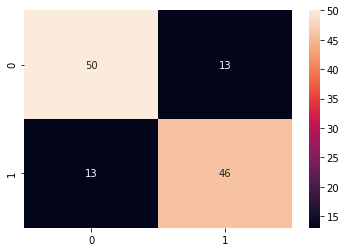

In [317]:
sns.heatmap(confusion_matrix(y_test, y_test_pred, labels = [1, 0]), annot = True);

In [318]:
cv_log_model = cross_validate(log_model, X_train, y_train, cv = 10, scoring = ['accuracy', 'f1'])
cv_log_model

{'fit_time': array([0.02256083, 0.03904986, 0.01743102, 0.01541615, 0.01244593,
        0.01313806, 0.01270175, 0.01321101, 0.01276422, 0.0137291 ]),
 'score_time': array([0.00414824, 0.00412393, 0.00281405, 0.00286889, 0.00265193,
        0.00261593, 0.00299406, 0.00271988, 0.00269008, 0.002635  ]),
 'test_accuracy': array([0.87179487, 0.84615385, 0.84615385, 0.71794872, 0.71794872,
        0.71794872, 0.84615385, 0.76923077, 0.65789474, 0.84210526]),
 'test_f1': array([0.87804878, 0.86363636, 0.85714286, 0.74418605, 0.7755102 ,
        0.73170732, 0.86363636, 0.79069767, 0.66666667, 0.85      ])}

In [319]:
cv_log_model['test_accuracy'].mean()

0.7833333333333333

In [320]:
cv_log_model['test_f1'].mean()

0.8021232273655092

In [331]:
LogisticRegression()


random_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'tol': stats.loguniform(0.1, 1),
    'C': stats.loguniform(3, 10)
    }

log_model_rand_search = RandomizedSearchCV(log_model, param_distributions = random_grid, 
                                           n_iter = 100, cv = 10, scoring = 'f1', verbose = 1, n_jobs = -1)

In [332]:
log_model_rand_search.fit(X_train[numeric_features], y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13086ceb0>,
                                        'penalty': ['l2', 'l1', 'elasticnet'],
                                        'tol': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1307eac70>},
                   scoring='f1', verbose=1)

In [333]:
log_model_rand_search.best_params_

{'C': 3.1369608780142615, 'penalty': 'l2', 'tol': 0.6394563946341022}

In [334]:
y_val_pred_log_model_rand_search = log_model_rand_search.predict(X_val[numeric_features])

In [335]:
print(classification_report(y_val, y_val_pred_log_model_rand_search))

              precision    recall  f1-score   support

           0       0.70      0.67      0.68        39
           1       0.78      0.81      0.80        58

    accuracy                           0.75        97
   macro avg       0.74      0.74      0.74        97
weighted avg       0.75      0.75      0.75        97



## Baseline Model